In [1]:
import cv2
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import json
import numpy as np
import seaborn as sns
import math
from scipy.special import expit

# Video class initial


In [2]:
class Video():
    
    def __init__(self, video_info: dict):
        '''
        Take video_info as input.
        
        video input:
            1. 'dataset_root'
            2. 'dataset_name'
            3. 'video_name'
            4. 'video_type'
        '''
        self.action_path = video_info['dataset_root'] + '/' + video_info['dataset_name'] + '/' + video_info['video_action']
        self.video_path = self.action_path + '/' + video_info['video_type'] + '/' + video_info['video_name']
        self.calibration_path = self.action_path + '/calibration_' + video_info['video_action'] + '.json'
        self.hd_cam_id = video_info['hd_cam_id']
        
        self._now_frame_num = -1
        self._pre_frame_num = self._now_frame_num
        
        self.now_frame = None
        self.video_capture = None
        self.detect_info = {}
    def read(self)-> list:
        
        '''
        Return a list of VideoCapture objects.
        '''
        
        self.video_capture = cv2.VideoCapture(self.video_path)

        if self.video_capture.isOpened():
          
            print(f'Successfully read video! \nThe video path is: {self.video_path}\n')
        else:
            print(f'Failed to read video...\nThe video path is: {self.video_path}\n')
            
    @property
    def now_frame_num(self):
        return self._now_frame_num
  
    @now_frame_num.setter
    def now_frame_num(self, now_frame_num):
        assert(self.video_capture is not None), "Video Captuer is Empty. Please run 'read' function to read video first." 
        
        self._now_frame_num = now_frame_num
        if self._now_frame_num == self._pre_frame_num:
            pass
        
        elif self._now_frame_num <= self._pre_frame_num:
            self.read()
            self.get_specific_frame(self._now_frame_num)
            
        else:
            push_frame_num = now_frame_num - self._pre_frame_num
            self.get_specific_frame(push_frame_num)
        
        self._pre_frame_num = self._now_frame_num
            
    def get_specific_frame(self, sp_frame):
        assert (self.video_capture.isOpened), 'VideoCaptures is empty. Please run method "read" '

        frame_num = 0
        while frame_num <= sp_frame:   
            success, frame = self.video_capture.read()
            if not success:
                break
            frame_num += 1
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.now_frame = frame
    
    def crop_bbox(self, kpt2D, frame = None):
        info_list = []
        
        for info in kpt2D:
            xyxy = info['bbox'].astype('int')
            if frame is None:
                crop = self.now_frame[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
            else:
                crop = frame[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
            info['crop'] = crop
            info_list.append(info)
            
        self.detect_info[str(self._now_frame_num)] = info_list
    
    def show_crop_image(self, frame_num):
        people_nums = len(self.detect_info[str(frame_num)])
        plt.figure()

        #subplot(r,c) provide the no. of rows and columns
        f, axarr = plt.subplots(1,people_nums+1) 
    
        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        axarr[0].imshow(self.now_frame)
        for p in range(people_nums):
            axarr[p+1].imshow(self.detect_info[str(frame_num)][p]['crop'])
    
    def load_calibration_parameters(self):
        with open(self.calibration_path) as cfile:
            calib = json.load(cfile)

        # Cameras are identified by a tuple of (panel#,node#)
        cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}
        
        # Convert data into numpy arrays for convenience
        
        for k,cam in cameras.items():
            if cam['name'] == f'00_{self.hd_cam_id}':
                cam['K'] = np.matrix(cam['K'])
                cam['distCoef'] = np.array(cam['distCoef'])
                cam['R'] = np.matrix(cam['R'])
                cam['t'] = np.array(cam['t']).reshape((3,1))
                self.calibration_parameter = cam

# Load detection model

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x')

Using cache found in /home/aaron/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-6-10 Python-3.8.13 torch-1.10.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7979MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


In [4]:
#yolo setting

model.conf = 0.25         # NMS confidence threshold
model.iou = 0.45          # NMS IoU threshold
model.agnostic = False    # NMS class-agnostic
model.multi_label = False # NMS multiple labels per box
model.classes = [0]       # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
model.max_det = 1000      # maximum number of detections per image
model.amp = False         # Automatic Mixed Precision (AMP) inference

# Load MMpose detection model

In [5]:
import mmcv
from mmpose.apis import (extract_pose_sequence, get_track_id,
                         inference_pose_lifter_model,
                         inference_bottom_up_pose_model,
                         inference_top_down_pose_model, init_pose_model,
                         process_mmdet_results, vis_pose_result, vis_3d_pose_result, vis_pose_tracking_result)
from mmpose.core import Smoother
from mmdet.apis import inference_detector, init_detector

from mmpose.datasets import DatasetInfo

In [6]:
class detection_2Dkpts_model():
    
    def __init__(self, config_path, ckpt_path, smooth_cfg, draw_info):
        
        
        '''
        pose 2D config and ckpt
        
        '''
        
      
        #Top Down
        pose_detector_config = config_path
        pose_detector_checkpoint = ckpt_path
        
        # gpu id
        device = 'cuda:1'
        
        # initial pose model
        self.pose_det_model = init_pose_model(
            pose_detector_config,
            pose_detector_checkpoint,
            device=device)
        
        # initial smoother
        smooth_filter_cfg = smooth_cfg
        self.smoother2D = Smoother(filter_cfg=smooth_filter_cfg, keypoint_dim=2)
        
        # set dataset config
        self.pose_det_dataset = self.pose_det_model.cfg.data['test']['type']
        self.pose_dataset_info = self.pose_det_model.cfg.data['test'].get('dataset_info', None)
        if self.pose_dataset_info is None:
            warnings.warn(
                'Please set `dataset_info` in the config.'
                'Check https://github.com/open-mmlab/mmpose/pull/663 for details.',
                DeprecationWarning)
            assert (self.pose_det_dataset == 'BottomUpCocoDataset')
        else:
            self.pose_dataset_info = DatasetInfo(self.pose_dataset_info)
        
        # drawing parameter
        self.radius = draw_info['radius']
        self.thickness = draw_info['thickness']
        self.visualization = draw_info['visualization']

        
    def __call__(self, frame, detect_result):
        
        detect_result = self.convert_object_detection_definition(detect_result)
     
        pose_det_results, _ = inference_top_down_pose_model(
                self.pose_det_model,
                frame,
                detect_result,
                bbox_thr=0.65,
                format='xyxy',
                dataset=self.pose_det_dataset,
                return_heatmap=False,
                outputs=None)
            
        pose_det_results = self.smoother2D.smooth(pose_det_results)
        
        if self.visualization: 
            frame = vis_pose_result(
                self.pose_det_model,
                frame,
                pose_det_results,
                radius=self.radius,
                thickness=self.thickness,
                dataset=self.pose_det_dataset,
                dataset_info=self.pose_dataset_info,
                kpt_score_thr=0.3,
                show=False,
                out_file=None)
        
        return frame, pose_det_results
    
    def convert_object_detection_definition(self, detect_result):
        
        # yolov5 converter
        #Deal with single frame
        np_detect_result = detect_result.xyxy[0].cpu().numpy()
        
        if np_detect_result.shape[0] == 0:
            return []
        
        convert_result = []
        for bbox in np_detect_result:
            convert_result.append({'bbox': bbox[:-1]})
            
       
            
        return convert_result

In [7]:
draw_info = {
    'radius': 5,
    'thickness' : 2,
    'visualization': True
}

In [8]:
folder_root = '/home/aaron/Desktop/Aaron/S200/mmpose_test/3D_pose_sview_multiperson'
config_path = f'{folder_root}/mmpose/2D/configs/Top_down/hrnet_w48_coco_256x192.py'
ckpt_path   = f'{folder_root}/mmpose/2D/ckpts/Top_down/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth'
smooth_cfg = f'{folder_root}/mmpose/smoother/one_euro.py'

HRNet = detection_2Dkpts_model(config_path, ckpt_path, smooth_cfg, draw_info)

load checkpoint from local path: /home/aaron/Desktop/Aaron/S200/mmpose_test/3D_pose_sview_multiperson/mmpose/2D/ckpts/Top_down/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth


# Load frame and test

In [9]:
video_info = {
    'dataset_root': '/media/aaron/963AA6803AA65D4D/dataset',
    'dataset_name': 'CMU/panoptic-toolbox',
    'video_action': '160906_band1',
    'video_type': 'hdVideos',
    'video_name': 'hd_00_00.mp4'  
}

In [10]:

video_info_list = []
for i in range(5):  
    video_info['video_name'] = f'hd_00_0{i}.mp4'
    video_info['hd_cam_id'] = str(i).zfill(2)
    video_info_list.append(video_info.copy())

In [ ]:
video_info = {
    'dataset_root': '/home/aaron/Desktop/Aaron/S200/anti_masking/',
    'dataset_name': 'video',
    'video_action': 'walking',
    'video_type': '720p',
    'video_name': 'walking_00.mp4'  
}

In [ ]:

video_info_list = []
for i in range(3):  
    video_info['video_name'] = f'walking_0{i}.mp4'
    video_info['hd_cam_id'] = str(i).zfill(2)
    video_info_list.append(video_info.copy())

In [11]:

CMU_video_list = []

for v in video_info_list:
    CMU_video = Video(v)
    CMU_video.read()
    CMU_video_list.append(CMU_video)

Successfully read video! 
The video path is: /media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/160906_band1/hdVideos/hd_00_00.mp4

Successfully read video! 
The video path is: /media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/160906_band1/hdVideos/hd_00_01.mp4

Successfully read video! 
The video path is: /media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/160906_band1/hdVideos/hd_00_02.mp4

Successfully read video! 
The video path is: /media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/160906_band1/hdVideos/hd_00_03.mp4

Successfully read video! 
The video path is: /media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/160906_band1/hdVideos/hd_00_04.mp4



In [12]:
for v in CMU_video_list:
    v.load_calibration_parameters()

<Figure size 432x288 with 0 Axes>

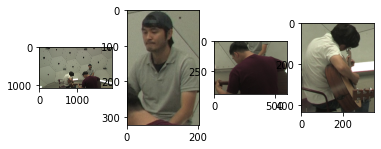

<Figure size 432x288 with 0 Axes>

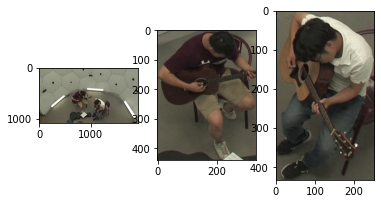

<Figure size 432x288 with 0 Axes>

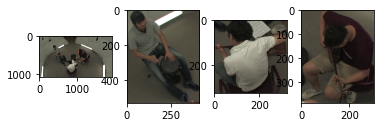

<Figure size 432x288 with 0 Axes>

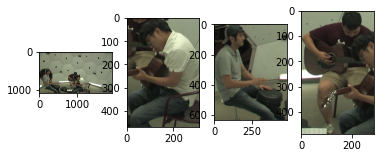

<Figure size 432x288 with 0 Axes>

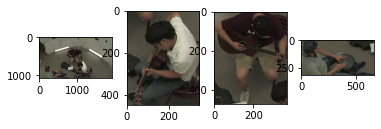

In [13]:
%matplotlib inline
for v in range(len(CMU_video_list)):
    select_frame = 1500
    select_camera = v
    CMU_video_list[select_camera].now_frame_num = select_frame

    result = model(CMU_video_list[select_camera].now_frame)

    frame, kpt2D = HRNet(CMU_video_list[select_camera].now_frame, result)
    CMU_video_list[select_camera].crop_bbox(kpt2D)

    CMU_video_list[select_camera].show_crop_image(select_frame)

# Cross-view matching

### class of similarity


In [14]:
class similarity_matrix():
    
    def __init__(self, v1: Video, v2: Video, frame_num: int):
        self.v1 = v1
        self.v2 = v2
        self.frame_num = str(frame_num)
        self.v1_bbox_cunt = len(self.v1.detect_info[self.frame_num])
        self.v2_bbox_cunt = len(self.v2.detect_info[self.frame_num])
        self.total_cunt = self.v1_bbox_cunt + self.v2_bbox_cunt
        
        self.apearance_similarity_matrix = np.zeros((self.v1_bbox_cunt, self.v2_bbox_cunt))
        self.geometric_similarity_matrix = np.zeros((self.v1_bbox_cunt, self.v2_bbox_cunt))
        
    def calculate_apearance_similarity(self, feature__encoding_model):
        v1_bbox = [detect['crop'] for detect in self.v1.detect_info[self.frame_num]]
        v2_bbox = [detect['crop'] for detect in self.v2.detect_info[self.frame_num]]
#         total_bbox = v1_bbox + v2_bbox
        
        for i in range(self.v1_bbox_cunt):
            for j in range(self.v2_bbox_cunt):
                
                crop1 = v1_bbox[i]
                crop2 = v2_bbox[j]
                
                crop1 = torch.tensor(crop1.astype('float32').transpose(2, 0, 1))
                crop2 = torch.tensor(crop2.astype('float32').transpose(2, 0, 1))

                discriptor1 = feature__encoding_model(crop1)
                discriptor2 = feature__encoding_model(crop2)

                distance = np.sum(((discriptor1-discriptor2)**2).cpu().numpy())**0.5
                
                #affinity_matrix is symmetric
                self.apearance_similarity_matrix[i, j] = distance
#                 self.apearance_similarity_matrix[j, i] = distance
                
        return self.apearance_similarity_matrix
        
    def calculate_geometric_similarity(self, calibrate = False):
        
        
        if calibrate == True:
            
            R1 = self.v1.calibration_parameter['R']
            T1 = self.v1.calibration_parameter['t'].reshape(3,)
            K1 = self.v1.calibration_parameter['K']

            R2 = self.v2.calibration_parameter['R']
            T2 = self.v2.calibration_parameter['t'].reshape(3,)
            K2 = self.v2.calibration_parameter['K']
            
            fund_mat= self.get_fundamental_matrix(R1, T1, K1, R2, T2, K2)
            
        else:
            
            fund_mat = self.get_fundamental_matrix_8pts(self.v1.now_frame, self.v2.now_frame)
            
        v1_kpts = [detect['keypoints'] for detect in self.v1.detect_info[self.frame_num]]
        v2_kpts = [detect['keypoints'] for detect in self.v2.detect_info[self.frame_num]]
     
#         total_kpts = v1_kpts + v2_kpts
#         total_kpts_num = len(total_kpts)
       

        
        for i in range(self.v1_bbox_cunt):
            for j in range(self.v2_bbox_cunt):
                
                # Each bbox pair should calculate one geometric_similarity
                bbox_geometric_similarity = 0
                joints1 = v1_kpts[i]
                joints2 = v2_kpts[j]
                
                
                for joint in range(joints1.shape[0]):
                    
                    # The geometric_similarity average from each joint difference.  
                    
                    kp1 = joints1[joint][:2]
                    kp2 = joints2[joint][:2]
               
                    # view1
                    lines1 = cv2.computeCorrespondEpilines(kp2.reshape(-1, 1, 2), 1, fund_mat)
                    lines1 = lines1.reshape(-1, 3)
                    distance1 = self.point2line_distance(kp1, lines1[0])

                    # view2
                    lines2 = cv2.computeCorrespondEpilines(kp1.reshape(-1, 1, 2), 2, fund_mat)
                    lines2 = lines2.reshape(-1, 3)
                    distance2 = self.point2line_distance(kp2, lines2[0])

                    total_distance = distance1 + distance2

                    bbox_geometric_similarity += total_distance
        
                bbox_geometric_similarity /= (joints1.shape[0] * 2)
                self.geometric_similarity_matrix[i, j] = bbox_geometric_similarity
#                 self.geometric_similarity_matrix[j, i] = bbox_geometric_similarity
                
        return self.geometric_similarity_matrix
    
    def get_fundamental_matrix_8pts(self, img1, img2):
        # 1. Detect keypoints and their descriptors
        # Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1, None)
        kp2, des2 = sift.detectAndCompute(img2, None)

        # Visualize keypoints
        imgSift = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # Match keypoints in both images
        # Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Keep good matches: calculate distinctive image features
        # Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
        # https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
        matchesMask = [[0, 0] for i in range(len(matches))]
        good = []
        pts1 = []
        pts2 = []

        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                # Keep this keypoint pair
                matchesMask[i] = [1, 0]
                good.append(m)
                pts2.append(kp2[m.trainIdx].pt)
                pts1.append(kp1[m.queryIdx].pt)

        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)
        fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

        return fundamental_matrix
        
    def get_fundamental_matrix(self, R1, T1, K1, R2, T2, K2):
        # compute transformation matrix from world coordinate to camera system
        P1 = np.eye(4)
        P1[:3,:3] = R1
        P1[:3, 3] = T1

        P2 = np.eye(4)
        P2[:3,:3] = R2
        P2[:3, 3] = T2

        # compute transformation matrix from camera2 to camera1
        P = P1 @ np.linalg.inv(P2)
        R = P[:3,:3]
        T = P[:3, 3]

        def skew(x):
            x = x.flatten()
            return np.array([[    0,-x[2],  x[1]],
                             [ x[2],    0, -x[0]],
                             [-x[1], x[0],    0]])

        # essensial matrix
        E = skew(T) @ R
        F = np.linalg.inv(K1).T @ E @ np.linalg.inv(K2)

        F = F/ (F[2, 2] + 1e-40) #protect divide by zero

        return F
    
    def point2line_distance(self, point, line_ABC):
        '''
        lineABC: ax+by+c = 0
        '''

        numerator = np.abs(line_ABC[0] * point[0] + line_ABC[1] * point[1] + line_ABC[2])
        denominator = (line_ABC[0] ** 2 + line_ABC[1] **2) ** 0.5

        return numerator / denominator
    
    def drawlines(self, img1color, lines, pts1src):
        ''' img1 - image on which we draw the epilines for the points in img2
            lines - corresponding epilines '''
        r, c,_ = img1color.shape
    #     img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
        # Edit: use the same random seed so that two images are comparable!
        np.random.seed(0)
        for r, pt1 in zip(lines, pts1src):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2]/r[1]])
            x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
            img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 10)
            img1color = cv2.circle(img1color, tuple(pt1), 30, color, -1)

        return img1color
    
    def show_geommetric_result(self):
        pass
        
        

In [15]:
class Fusion_affinity_matrix:
    
    def __init__(self, video_list: list, frame_num: int, extractor):
        '''
        video_list: a list of class "Video".
        extractor: re-ID model.
        
        '''
        self.video_list = video_list
#         self.fusion_matrix = 
        self.frame_num = frame_num
        self.total_bbox_cunt = self.calculate_total_bbox()
        
        self.fusion_affinity_matrix = np.zeros((self.total_bbox_cunt, self.total_bbox_cunt))
        self.appearance_matrix = np.zeros((self.total_bbox_cunt, self.total_bbox_cunt))
        self.geometric_matrix = np.zeros((self.total_bbox_cunt, self.total_bbox_cunt))
        
        self.video_cunt = len(video_list)
        self.extractor = extractor
    def create_similarity_matrix(self):
        
        # appearance_matrix is "symmetric"
        # use a dict to collect which submatrix is calculated.
        
        calculated_appearance_matrix = {}
        calculated_geometric_matrix = {}
        
        # calculate upper half triangle matrix
        for v1 in range(self.video_cunt):
            
            for v2 in range(v1, self.video_cunt):
                
                simularity_calculator = similarity_matrix(self.video_list[v1], self.video_list[v2], self.frame_num)
                local_appearance_matrix = simularity_calculator.calculate_apearance_similarity(self.extractor)
                local_geometric_matrix = simularity_calculator.calculate_geometric_similarity(calibrate=True)
                
                calculated_appearance_matrix[f'{v1}{v2}'] = local_appearance_matrix
                calculated_geometric_matrix[f'{v1}{v2}'] = local_geometric_matrix
                
        # create a ghost cell for concate row matrix
        # will be removed after concate
        tmp_appearance_row_matrix = np.zeros((1, self.total_bbox_cunt))
        tmp_geometric_row_matrix = np.zeros((1, self.total_bbox_cunt))
        
        # calculate full appearance matrix based on "calculated_matrix_dict"
        for i in range(self.video_cunt):
            
            # create a ghost cell for concate column matrix
            tmp_appearance_column_matrix = np.zeros((calculated_appearance_matrix[f'{i}{i}'].shape[0], 1))
            tmp_geometric_column_matrix = np.zeros((calculated_geometric_matrix[f'{i}{i}'].shape[0], 1))
            
            for j in range(self.video_cunt):

                if i > j:
                    # because is symmetric
                    tmp_appearance_matrix = calculated_appearance_matrix[f'{j}{i}'].transpose()
                    tmp_geometric_matrix = calculated_geometric_matrix[f'{j}{i}'].transpose()
                    
                else:
                    tmp_appearance_matrix = calculated_appearance_matrix[f'{i}{j}']
                    tmp_geometric_matrix = calculated_geometric_matrix[f'{i}{j}']
                    
                tmp_appearance_column_matrix = np.concatenate((tmp_appearance_column_matrix, tmp_appearance_matrix), axis = 1)
                tmp_geometric_column_matrix = np.concatenate((tmp_geometric_column_matrix, tmp_geometric_matrix), axis = 1)
            
            # removed ghost cell and concatenate to row matrix
            tmp_appearance_row_matrix = np.concatenate((tmp_appearance_row_matrix, tmp_appearance_column_matrix[:, 1:]), axis = 0)
            tmp_geometric_row_matrix = np.concatenate((tmp_geometric_row_matrix, tmp_geometric_column_matrix[:, 1:]), axis = 0)
        
        # removed ghost cell and normalize to [0, 1]
        # For identify similarity, inverse the value by substract 1
        
        
        self.appearance_matrix = 1-self.sigmoid(tmp_appearance_row_matrix[1:, :])
        self.geometric_matrix = 1-self.sigmoid(tmp_geometric_row_matrix[1:, :])
        
        return self.appearance_matrix, self.geometric_matrix
    
    def create_fusion_affinity_matrix(self):
        tmp_G = self.geometric_matrix.copy()
        th = 0.95
        
        tmp_G[tmp_G <= th] = 0
        
        fusion = (self.appearance_matrix * tmp_G)**0.5
        
        return fusion
        
        
    def calculate_total_bbox(self):
        bbox_count = 0
        for v in self.video_list:
            bbox_count += len(v.detect_info[str(self.frame_num)])
        return bbox_count
    
    def normalize_0_1(self, matrix:np.array):
        maxi = np.max(matrix)
        mini = np.min(matrix)
        return (matrix - mini) / (maxi - mini)
        
    
    def sigmoid(self, x:np.array):
        x = (x - x.mean ()) / x.std ()
        # TODO: add flexible factor
        x = 1 / (1 + np.exp ( -5 * x ))
        return x

## Calculate fusion similarity matrix

In [16]:
import torchreid
from torchreid.utils import FeatureExtractor

In [17]:
datamanager = torchreid.data.ImageDataManager(
    root="../reid-data",
    sources="market1501",
    targets="market1501",
    height=256,
    width=128,
    batch_size_train=32,
    batch_size_test=100,
    transforms=["random_flip"]
)

Building train transforms ...
+ resize to 256x128
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  -------------

In [18]:
model = torchreid.models.build_model(
    name="osnet_x1_0",
    num_classes=datamanager.num_train_pids,
    pretrained=True
)

Successfully loaded imagenet pretrained weights from "/home/aaron/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [19]:
torchreid.utils.load_pretrained_weights(model, '/home/aaron/Desktop/Aaron/S200/anti_masking/log/osnet_x1_0_ONLY_RANDOMFLIP/model/model.pth.tar-60')

Successfully loaded pretrained weights from "/home/aaron/Desktop/Aaron/S200/anti_masking/log/osnet_x1_0_ONLY_RANDOMFLIP/model/model.pth.tar-60"


In [20]:
extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/home/aaron/Desktop/Aaron/S200/anti_masking/log/osnet_x1_0_ONLY_RANDOMFLIP/model/model.pth.tar-60',
    device='cuda'
)

Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/home/aaron/Desktop/Aaron/S200/anti_masking/log/osnet_x1_0_ONLY_RANDOMFLIP/model/model.pth.tar-60"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [23]:
F = Fusion_affinity_matrix(CMU_video_list, frame_num=1500, extractor=extractor)

In [24]:
A, G = F.create_similarity_matrix()

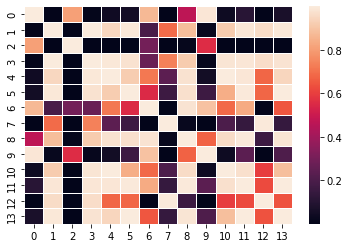

In [25]:
ax = sns.heatmap(F.appearance_matrix, linewidth=0.5)

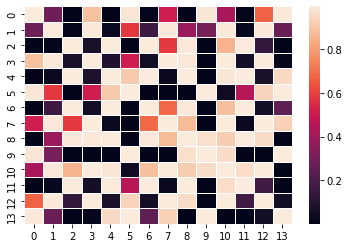

In [26]:
ax = sns.heatmap(F.geometric_matrix, linewidth=0.5)

In [27]:
fusion_matrix = F.create_fusion_affinity_matrix()

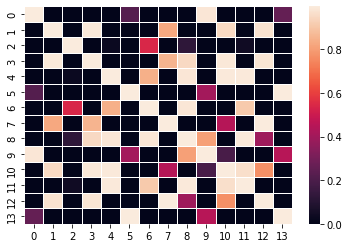

In [28]:
ax = sns.heatmap(fusion_matrix, linewidth=0.5)

In [ ]:
import cv2
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import json
import numpy as np
import seaborn as sns

In [ ]:
fusion_matrix = np.array([[    0.99825,           0,           0,      0.9748,           0,           0,           0,     0.14632,           0,     0.89858,           0,     0.45173,           0,           0],
       [          0,     0.99825,           0,           0,           0,     0.47991,           0,           0,           0,           0,      0.1194,           0,    0.026909,           0],
       [          0,           0,     0.99825,           0,      0.1089,           0,     0.91044,           0,     0.98827,           0,           0,           0,           0,     0.97599],
       [     0.9748,           0,           0,     0.99825,           0,           0,           0,     0.69417,           0,     0.98496,     0.96449,     0.94611,           0,           0],
       [          0,           0,      0.1089,           0,     0.99825,           0,           0,           0,    0.033724,           0,           0,           0,           0,           0],
       [          0,     0.47991,           0,           0,           0,     0.99825,           0,           0,           0,           0,     0.98857,           0,     0.88867,           0],
       [          0,           0,     0.91044,           0,           0,           0,     0.99825,           0,     0.82573,           0,           0,           0,           0,     0.99249],
       [    0.14632,           0,           0,     0.69417,           0,           0,           0,     0.99825,           0,     0.26942,           0,     0.99514,           0,           0],
       [          0,           0,     0.98827,           0,    0.033724,           0,     0.82573,           0,     0.99825,     0.44884,      0.9584,           0,           0,     0.97863],
       [    0.89858,           0,           0,     0.98496,           0,           0,           0,     0.26942,     0.44884,     0.99825,           0,     0.55389,     0.96048,           0],
       [          0,      0.1194,           0,     0.96449,           0,     0.98857,           0,           0,      0.9584,           0,     0.99825,           0,     0.99049,           0],
       [    0.45173,           0,           0,     0.94611,           0,           0,           0,     0.99514,           0,     0.55389,           0,     0.99825,           0,           0],
       [          0,    0.026909,           0,           0,           0,     0.88867,           0,           0,           0,     0.96048,     0.99049,           0,     0.99825,           0],
       [          0,           0,     0.97599,           0,           0,           0,     0.99249,           0,     0.97863,           0,           0,           0,           0,     0.99825]])

In [ ]:
fusion_matrix= np.array([[    0.99675,           0,           0,     0.96672,           0,           0,     0.50011,           0,     0.37229,           0,           0,     0.87561],
       [          0,     0.99675,           0,           0,     0.97967,           0,           0,     0.97283,           0,           0,           0,           0],
       [          0,           0,     0.99675,           0,           0,     0.33276,           0,           0,           0,     0.98288,     0.98915,           0],
       [    0.96672,           0,           0,     0.99675,           0,           0,     0.86598,           0,     0.49576,           0,           0,      0.9824],
       [          0,     0.97967,           0,           0,     0.99675,           0,           0,     0.96207,           0,           0,     0.31336,           0],
       [          0,           0,     0.33276,           0,           0,     0.99675,           0,           0,           0,     0.94414,     0.88971,           0],
       [    0.50011,           0,           0,     0.86598,           0,           0,     0.99675,           0,    0.018432,           0,           0,     0.99172],
       [          0,     0.97283,           0,           0,     0.96207,           0,           0,     0.99675,           0,           0,           0,           0],
       [    0.37229,           0,           0,     0.49576,           0,           0,    0.018432,           0,     0.99675,           0,           0,    0.068455],
       [          0,           0,     0.98288,           0,           0,     0.94414,           0,           0,           0,     0.99675,     0.99185,           0],
       [          0,           0,     0.98915,           0,     0.31336,     0.88971,           0,           0,           0,     0.99185,     0.99675,           0],
       [    0.87561,           0,           0,      0.9824,           0,           0,     0.99172,           0,    0.068455,           0,           0,     0.99675]])

## Permutation

### Original objective function

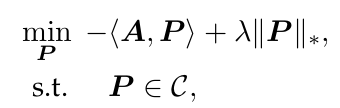

###  The problem is first rewritten as follows by introducing an auxiliary variable Q.

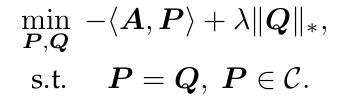

### Augmented Lagrangian

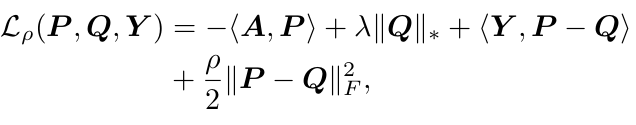

### Consistent Multi-Way Matching

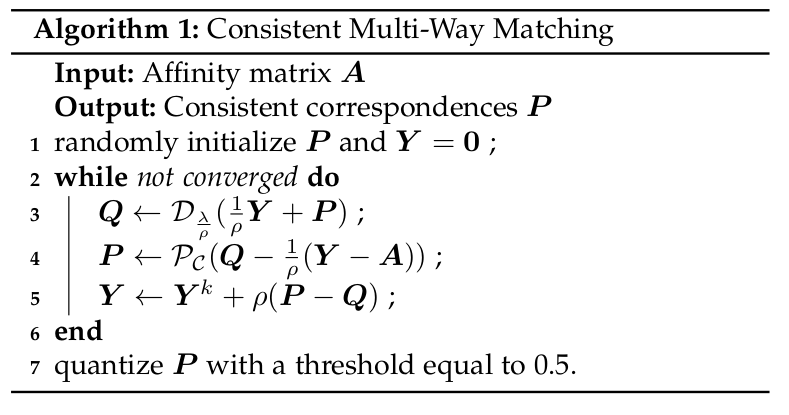

In [29]:
#Algo1

rho = 64
max_iter = 500
tol = 5e-4
alpha = 0.1
_lambda = 50


# Algo1, Step1

N = fusion_matrix.shape[0]
S = fusion_matrix.copy()
S[torch.arange ( N ), torch.arange ( N )] = 0

pos_train = np.where(S == 0)
S = (S+S.transpose()) / 2
P = S.copy()
Y = np.zeros((N, N))
W = alpha - S

for iter_ in range(max_iter):
    P0 = P.copy()
    
    # Algo1, step3 
    U, s, V = np.linalg.svd(Y/rho + P)
    diagS = s - _lambda/rho
    diagS[diagS < 0] = 0
    Q = U @ np.diag(diagS) @ V.transpose()
    
    # Algo1, Step4
    P = Q - (W+Y) / rho
    P[pos_train] = 0
    P[P < 0] = 0
    P[P > 1] = 1
    P[torch.arange(N), torch.arange(N)] = 1
    P = (P + P.transpose()) / 2
    
    # Algo step5
    Y = Y + rho*(P-Q)
    
    # test if convergence；
    pRes = np.linalg.norm(P - Q)  / N

    dRes = rho * np.linalg.norm(P - P0)  / N

    print(f'Iter: {iter_}, pRes: {pRes}, dRes: {dRes}, rho = {rho}')
    
    if pRes < tol and dRes < tol:
        break
        
    if pRes > 10 * dRes:
        rho = 2 * rho
        
    elif dRes > 10 * pRes:
        rho = rho / 2

Iter: 0, pRes: 0.3767753190197651, dRes: 28.79400913526918, rho = 64
Iter: 1, pRes: 0.5764774417983807, dRes: 5.5366215950529405, rho = 32.0
Iter: 2, pRes: 0.8220340105555677, dRes: 5.994310430412356, rho = 32.0
Iter: 3, pRes: 1.3203421862238767, dRes: 7.0191026830135, rho = 32.0
Iter: 4, pRes: 2.0807439658854654, dRes: 6.212410177583315, rho = 32.0
Iter: 5, pRes: 2.8157352919852845, dRes: 6.244793835821348, rho = 32.0
Iter: 6, pRes: 3.209852844521353, dRes: 4.991941716328275, rho = 32.0
Iter: 7, pRes: 4.25016461476117, dRes: 6.439557698936986, rho = 32.0
Iter: 8, pRes: 5.307961279362082, dRes: 6.827263532473821, rho = 32.0
Iter: 9, pRes: 6.767637838170662, dRes: 7.967948031068593, rho = 32.0
Iter: 10, pRes: 8.228837543614588, dRes: 6.305396130791936, rho = 32.0
Iter: 11, pRes: 11.594368194304694, dRes: 4.92644857053667, rho = 32.0
Iter: 12, pRes: 14.954203384914736, dRes: 4.671181389497711, rho = 32.0
Iter: 13, pRes: 20.935565293854193, dRes: 5.966941337184804, rho = 32.0
Iter: 14, pR

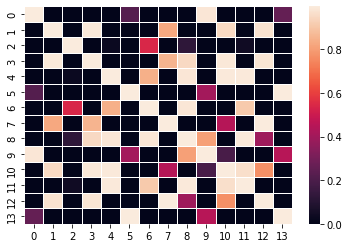

In [30]:
ax = sns.heatmap(fusion_matrix, linewidth=0.5)

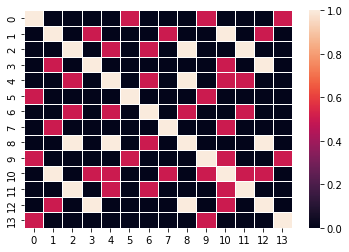

In [31]:
ax = sns.heatmap(P, linewidth=0.5)

In [32]:
P = (P + P.transpose())/2

In [33]:
P_bin = P >= 0.5

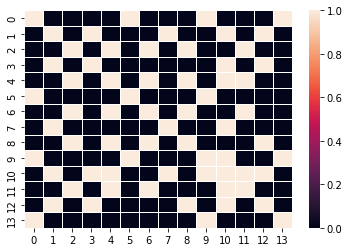

In [34]:
ax = sns.heatmap(P_bin, linewidth=0.5)

In [35]:
def transform_closure(X_bin):
    """
    Convert binary relation matrix to permutation matrix
    :param X_bin: torch.tensor which is binarized by a threshold
    :return:
    """
    
    N = X_bin.shape[0]
    temp = np.zeros((N, N))
    for k in range ( N ):
        for i in range ( N ):
            for j in range ( N ):
                temp[i][j] = X_bin[i, j] or (X_bin[i, k] and X_bin[k, j])
#     ax = sns.heatmap(temp, linewidth=0.5)
    vis = torch.zeros ( N )
    match_mat = np.zeros((N, N))
    for i, row in enumerate ( temp ):
        if vis[i]:
            continue
        for j, is_relative in enumerate ( row ):
            if is_relative:
                vis[j] = 1
                match_mat[j, i] = 1
    return match_mat

In [36]:
match_bin = transform_closure(P_bin)

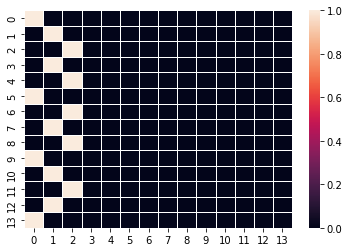

In [37]:
ax = sns.heatmap(match_bin, linewidth=0.5)

# Triangulation

### show ground truth

In [52]:
# Select HD Image index
hd_idx = 1500

# Setup paths
data_path = '/media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/'
seq_name = '160906_band1'

hd_skel_json_path = data_path+seq_name+'/hdPose3d_stage1_coco19/'

#hd_img_path = data_path+seq_name+'/hdImgs/'

colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()

<IPython.core.display.Javascript object>


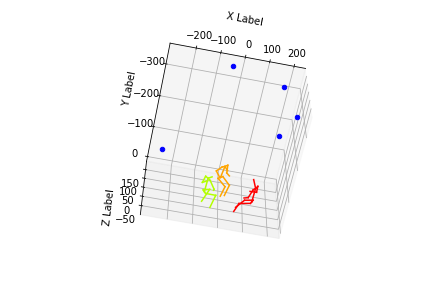

In [69]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev = -90, azim=-90)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# ax.axis('auto')

# Draw selected camera subset in blue


for cam in CMU_video_list:
    cc = np.dot(-cam.calibration_parameter['R'].transpose(), cam.calibration_parameter['t'])
    ax.scatter(cc[0], cc[1], cc[2], '.', color=[0,0,1])
#     ax.text(cc[0][0], cc[1][0], cc[2][0],  '%s' % (cam.calibration_parameter['name']))
'''
## Visualize 3D Body
'''
# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1

try:
    # Load the json file with this frame's skeletons
    skel_json_fname = hd_skel_json_path+'body3DScene_{0:08d}.json'.format(hd_idx)
    with open(skel_json_fname) as dfile:
        bframe = json.load(dfile)

    # Bodies
    for ids in range(len(bframe['bodies'])):
        body = bframe['bodies'][ids]
        skel = np.array(body['joints19']).reshape((-1,4)).transpose()

        for edge in body_edges:
            ax.plot(skel[0,edge], skel[1,edge], skel[2,edge], color=colors[body['id']])
            
except IOError as e:
    print('Error reading {0}\n'.format(skel_json_fname)+e.strerror)
plt.show()

    

In [99]:
CMU_video_list[0].now_frame_num = 1500

Successfully read video! 
The video path is: /media/aaron/963AA6803AA65D4D/dataset/CMU/panoptic-toolbox/160906_band1/hdVideos/hd_00_00.mp4



In [78]:
points1

array([     1315.8,      516.41], dtype=float32)

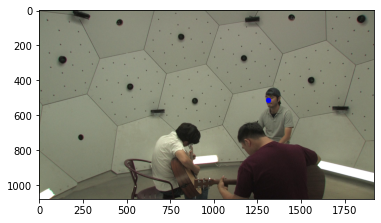

In [104]:
%matplotlib inline
points1 = CMU_video_list[0].detect_info['1500'][0]['keypoints'][0][:-1]
frame = cv2.circle(CMU_video_list[0].now_frame.copy(), (int(points1[0]), int(points1[1])),15, (0,0,255), -1)
plt.imshow(frame)

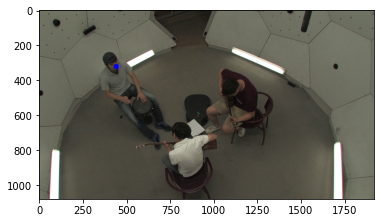

In [106]:
%matplotlib inline
points1 = CMU_video_list[2].detect_info['1500'][0]['keypoints'][0][:-1]
frame = cv2.circle(CMU_video_list[2].now_frame.copy(), (int(points1[0]), int(points1[1])),15, (0,0,255), -1)
plt.imshow(frame)

<Figure size 432x288 with 0 Axes>

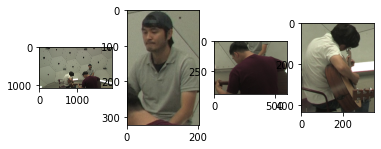

<Figure size 432x288 with 0 Axes>

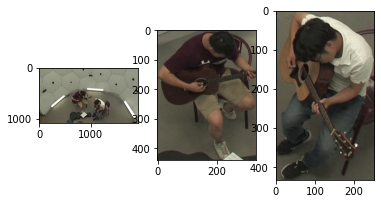

<Figure size 432x288 with 0 Axes>

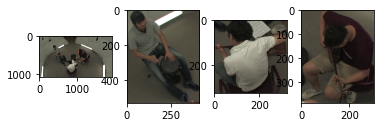

<Figure size 432x288 with 0 Axes>

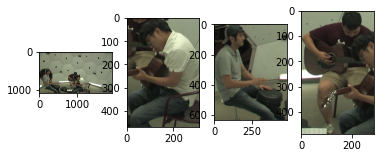

<Figure size 432x288 with 0 Axes>

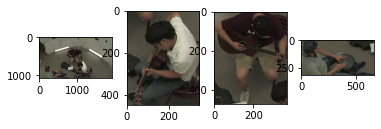

In [13]:
%matplotlib inline
for v in range(len(CMU_video_list)):
    select_frame = 1500
    select_camera = v
    CMU_video_list[select_camera].now_frame_num = select_frame

    result = model(CMU_video_list[select_camera].now_frame)

    frame, kpt2D = HRNet(CMU_video_list[select_camera].now_frame, result)
    CMU_video_list[select_camera].crop_bbox(kpt2D)

    CMU_video_list[select_camera].show_crop_image(select_frame)

In [196]:
def get_fundamental_matrix(R1, T1, K1, R2, T2, K2):
        # compute transformation matrix from world coordinate to camera system
        P1 = np.eye(4)
        P1[:3,:3] = R1
        P1[:3, 3] = T1

        P2 = np.eye(4)
        P2[:3,:3] = R2
        P2[:3, 3] = T2

        # compute transformation matrix from camera2 to camera1
        P = P1 @ np.linalg.inv(P2)
        R = P[:3,:3]
        T = P[:3, 3]

        def skew(x):
            x = x.flatten()
            return np.array([[    0,-x[2],  x[1]],
                             [ x[2],    0, -x[0]],
                             [-x[1], x[0],    0]])

        # essensial matrix
        E = skew(T) @ R
        F = np.linalg.inv(K1).T @ E @ np.linalg.inv(K2)

        F = F/ (F[2, 2]) #protect divide by zero

        return F

In [220]:
R1 = CMU_video_list[0].calibration_parameter['R']
T1 = CMU_video_list[0].calibration_parameter['t'].reshape(3,)
K1 = CMU_video_list[0].calibration_parameter['K']

R2 = CMU_video_list[3].calibration_parameter['R']
T2 = CMU_video_list[3].calibration_parameter['t'].reshape(3,)
K2 = CMU_video_list[3].calibration_parameter['K']

F = get_fundamental_matrix(R1, T1, K1, R2, T2, K2)

In [221]:
F

matrix([[ 7.0093e-09,  1.2536e-06, -0.00052476],
        [ 1.2513e-06,   6.644e-09,  -0.0016877],
        [-0.00054639, -0.00064286,           1]])

In [222]:
fundamental_matrix

array([[ 7.7127e-08,  9.3789e-07, -0.00065171],
       [-9.6099e-09,  1.4347e-07,  6.7678e-06],
       [-0.00012094,   -0.001394,           1]])

In [278]:
img1 = CMU_video_list[1].now_frame.copy()
img2 = CMU_video_list[4].now_frame.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [279]:
# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [280]:
# Visualize keypoints
imgSift = cv2.drawKeypoints(
    img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("SIFT Keypoints", cv2.resize(imgSift, (1920, 1080)))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [281]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [282]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, **draw_params)
cv2.imshow("Keypoint matches", cv2.resize(keypoint_matches, (1920, 1080)))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [283]:

# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

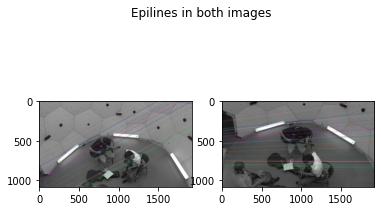

In [284]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left imaget
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [285]:

# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2= img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

In [286]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

True

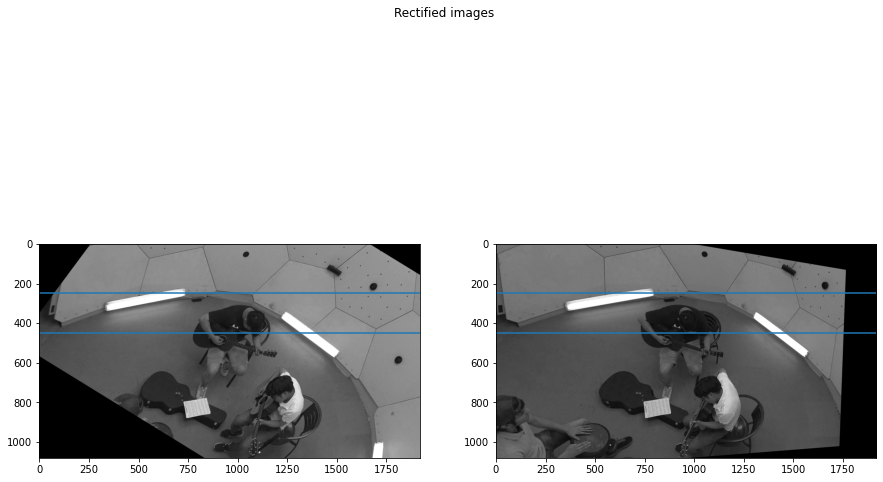

In [287]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

In [288]:
pt1 = []
pt2 = []

pt1.append(CMU_video_list[1].detect_info['1500'][0]['keypoints'][:, :-1])
pt1.append(CMU_video_list[1].detect_info['1500'][1]['keypoints'][:, :-1])
# pt1.append(CMU_video_list[0].detect_info['1500'][2]['keypoints'][:, :-1])

pt2.append(CMU_video_list[4].detect_info['1500'][1]['keypoints'][:, :-1])
pt2.append(CMU_video_list[4].detect_info['1500'][0]['keypoints'][:, :-1])


pt1 = np.concatenate((pt1[0], pt1[1]), axis = 0)
pt2 = np.concatenate((pt2[0], pt2[1]), axis = 0)

In [296]:
cv2.circle(img1, (int(pt1[10][0]), int(pt1[10][1])), 30, (255,255,255), -1)

array([[140, 140, 141, ..., 127, 127, 127],
       [140, 140, 141, ..., 131, 132, 132],
       [140, 141, 140, ..., 132, 132, 132],
       ...,
       [ 66,  63,  65, ..., 128, 130, 133],
       [ 65,  61,  63, ..., 129, 130, 133],
       [ 65,  62,  63, ..., 130, 130, 133]], dtype=uint8)

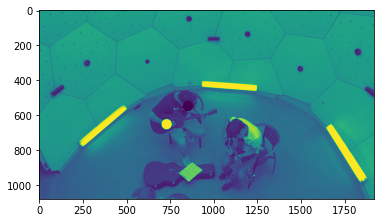

In [297]:
plt.imshow(img1)

In [268]:
from skimage.io import imread, imshow
from skimage import transform

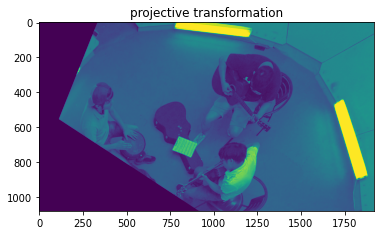

In [273]:
#using skimage’s transform module where ‘projective’ is our desired parameter
tform = transform.estimate_transform('projective', pts1, pts2)
tf_img = transform.warp(img2, tform.inverse)
#plotting the transformed image
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('projective transformation')